#Import

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.func import functional_call, vmap, vjp, jvp, jacrev
from functorch import make_functional
# import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [2]:
!pip install spicy

#Set test data

In [10]:
from spicy import io

mat_file = io.loadmat('/content/FluentSol.mat')

In [11]:
test_x = mat_file['x'][0].reshape(-1,1)
test_y = mat_file['y'][0].reshape(-1,1)
test_p = mat_file['p'][0].reshape(-1,1)
test_vx = mat_file['vx'][0].reshape(-1,1)
test_vy = mat_file['vy'][0].reshape(-1,1)

test_x_ = Variable(torch.from_numpy(test_x).float(), requires_grad=False).to(device)
test_y_ = Variable(torch.from_numpy(test_y).float(), requires_grad=False).to(device)
test_p_ = Variable(torch.from_numpy(test_p).float(), requires_grad=False).to(device)
test_vx_ = Variable(torch.from_numpy(test_vx).float(), requires_grad=False).to(device)
test_vy_ = Variable(torch.from_numpy(test_vy).float(), requires_grad=False).to(device)

#Build Network

In [13]:
M = 40

class Net_NS(nn.Module):
    def __init__(self):
        super(Net_NS, self).__init__()
        torch.manual_seed(333)
        self.hidden_layer1 = nn.Linear(2,M)
        torch.manual_seed(333)
        self.hidden_layer2 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer3 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer4 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer5 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.output_layer = nn.Linear(M,3)

    def forward(self, x,y):
        inputs = torch.cat([x,y],axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        out = self.output_layer(layer5_out)

        u = out[:, 0:1]
        v = out[:, 1:2]
        p = out[:, 2:3]

        return u , v , p

#set PDE,residual

In [47]:
N = 10

In [48]:
rho = 1.00
mu = 0.02

def ns(xy, net):
    x=xy[:, 0:1]
    y=xy[:, 1:2]

    u, v, p = net(x,y)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y.sum(), y, create_graph=True)[0]
    p_x = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    p_y = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    r_1 = (rho * (u*N*u_x+v*N*u_y) + N*p_x - mu*(N*N*u_xx + N*N*u_yy))/N
    r_2 = (rho * (u*N*v_x+v*N*v_y) + N*p_y - mu*(N*N*v_xx + N*N*v_yy))/N
    r_3 = (N*u_x+N*v_y)/N

    return r_1, r_2, r_3


#loss,optimizer

In [ ]:
import torch
import torch.nn.init as init

mse_cost_function = torch.nn.MSELoss() 

net_NS = Net_NS()
net_NS = net_NS.to(device)


for layer in net_NS.children():
    if isinstance(layer, torch.nn.Linear):
        init.xavier_uniform_(layer.weight) 

optimizer = torch.optim.Adam(net_NS.parameters(),lr=0.001)

#Set data set

In [50]:
def remove_pt_inside_cyl(xy_col, xc, yc, r):
    dst = np.array([((xy[0] - xc) ** 2 + (xy[1] - yc) ** 2) ** 0.5 for xy in xy_col])
    return xy_col[dst > r, :]

# define boundary condition
def func_u0(y):
    return 4 * y/N * (0.41 - y/N) / ((0.41) ** 2)


# set number of data points
N_b = 200    # inlet and outlet boundary
N_w = 400    # wall boundary
N_s = 200    # surface boundary
N_c = 6000  # collocation points
N_r = 600  # additional refining points

    # set boundary
xmin = 0.0
xmax = 1.1*N
ymin = 0.0
ymax = 0.41*N
r = 0.05*N
xc = 0.2*N
yc = 0.2*N

    # inlet boundary data, v=0
inlet_xy = np.linspace([xmin, ymin], [xmin, ymax], N_b)
# print(inlet_xy[:,1])
inlet_u = func_u0(inlet_xy[:, 1]).reshape(-1,1)
inlet_v = np.zeros((N_b,1))
inlet_uv = np.concatenate([inlet_u, inlet_v], axis=1)

    # outlet boundary condition, p=0
outlet_xy = np.linspace([xmax, ymin], [xmax, ymax], N_b)
outlet_p = np.zeros((N_b, 1))

    # wall boundary condition, u=v=0
wallup_xy = np.linspace([xmin, ymax], [xmax, ymax], N_w)
walldn_xy = np.linspace([xmin, ymin], [xmax, ymin], N_w)
wallup_uv = np.zeros((N_w, 2))
walldn_uv = np.zeros((N_w, 2))

    # cylinder surface, u=v=0
theta = np.linspace(0.0, 2 * np.pi, N_s)
cyld_x = (r * np.cos(theta) + xc).reshape(-1, 1)
cyld_y = (r * np.sin(theta) + yc).reshape(-1, 1)
cyld_xy = np.concatenate([cyld_x, cyld_y], axis=1)
cyld_uv = np.zeros((N_s, 2))

    # all boundary conditions except outlet
xy_bnd = np.concatenate([inlet_xy, wallup_xy, walldn_xy, cyld_xy], axis=0)
uv_bnd_sol = np.concatenate([inlet_uv, wallup_uv, walldn_uv, cyld_uv], axis=0)

    # refine points around cylider
x_col_refine = np.random.uniform(xc-2*r, xc+2*r, [N_r, 1])
y_col_refine = np.random.uniform(yc-2*r, yc+2*r, [N_r, 1])
xy_col_refine = np.concatenate([x_col_refine, y_col_refine], axis=1)

    # convert all to tensors
xy_bnd_ = Variable(torch.from_numpy(xy_bnd).float(), requires_grad=True).to(device)

uv_bnd_sol = Variable(torch.from_numpy(uv_bnd_sol).float(), requires_grad=False).to(device)
u_sol = uv_bnd_sol[:, 0:1]
v_sol = uv_bnd_sol[:, 1:2]

outlet_xy_ = Variable(torch.from_numpy(outlet_xy).float(), requires_grad=True).to(device)
outlet_p = Variable(torch.from_numpy(outlet_p).float(), requires_grad=False).to(device)

#Train (Adam)

In [ ]:
iterations = 80000
globals()["LBFGS_epoch"] = 0
previous_validation_loss = 99999999.0

for epoch in range(iterations):
    optimizer.zero_grad()

##------------------------------------Set Interior Domain-----------------------------------------##
    x_col = np.random.uniform(xmin, xmax, [N_c, 1])
    y_col = np.random.uniform(ymin, ymax, [N_c, 1])
    xy_col = np.concatenate([x_col, y_col], axis=1)

    xy_col = np.concatenate([xy_col, xy_col_refine], axis=0)

    # # remove collocation points inside the cylinder
    xy_col = remove_pt_inside_cyl(xy_col, xc=xc, yc=yc, r=r)

    # # concatenation of all boundary and collocation points
    xy_col = np.concatenate([xy_col, xy_bnd, outlet_xy], axis=0)

    # # convert all to tensors
    xy_col = Variable(torch.from_numpy(xy_col).float(), requires_grad=True).to(device)

    all_zeros = np.zeros((len(xy_col),1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
##------------------------------------Compute Loss-----------------------------------------##

    r_1, r_2, r_3 = ns(xy_col,net_NS)
    u_hat, v_hat, _ = net_NS(xy_bnd_[:, 0:1],xy_bnd_[:, 1:2])
    _, _, p_hat = net_NS(outlet_xy_[:, 0:1],outlet_xy_[:, 1:2])

    mse_r1 = mse_cost_function(r_1,pt_all_zeros)
    mse_r2 = mse_cost_function(r_2,pt_all_zeros)
    mse_r3 = mse_cost_function(r_3,pt_all_zeros)

    mse_bnd_u = mse_cost_function(u_hat,u_sol)
    mse_bnd_v = mse_cost_function(v_hat,v_sol)

    mse_outlet = mse_cost_function(p_hat,outlet_p)

    loss = (1)*(mse_r1 + mse_r2 + mse_r3) + 2*(mse_bnd_u + mse_bnd_v) + 2*mse_outlet

##------------------------------------Optimize Loss-----------------------------------------##

    loss.backward()
    optimizer.step()

##----------------------------Result-----------------------------##
    if (epoch) % 50 == 1:
        tmp_u , tmp_v, tmp_p = net_NS(N*test_x_,N*test_y_)

        error_p = torch.sqrt(((test_p_-tmp_p)**2).mean())/torch.sqrt((test_p_**2).mean())
        error_velocity = torch.sqrt(((test_vy_-tmp_v)**2+(test_vx_-tmp_u)**2).mean())/torch.sqrt((test_vy_**2+test_vx_**2).mean())

        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)

        print(error_p)
        print(error_velocity)
        print(loss)

-----------------------------------------------------------------------------
Epoch: 1
tensor(1.0395, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9452, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 51
tensor(1.0395, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9443, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 101
tensor(1.0389, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9437, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 151
tensor(1.0378, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9432, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0217, device='cuda:0',

#Plotting Prediction

<Figure size 640x480 with 0 Axes>

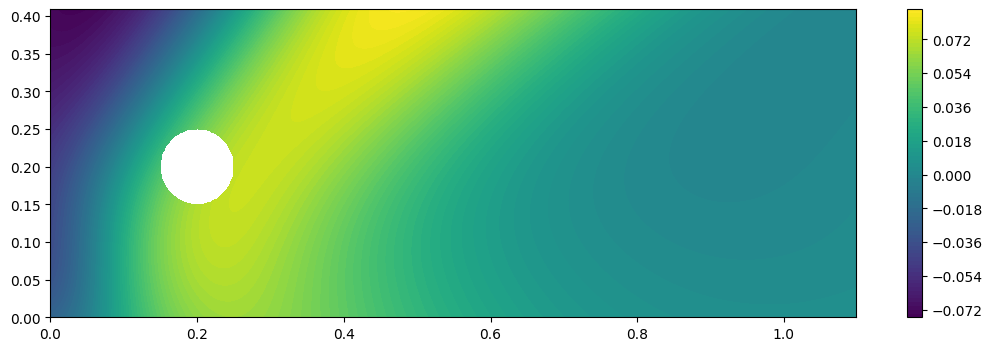

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
plt.figure(figsize=(13,4))

x_ = np.arange(0,1.1,0.001)
y_ = np.arange(0,0.41,0.001)

ms_x_ , ms_y_= np.meshgrid(x_,y_)

x_ = np.ravel(ms_x_).reshape(-1,1)
y_ = np.ravel(ms_y_).reshape(-1,1)

pt_x_ = Variable(torch.from_numpy(x_).float(), requires_grad=True).to(device)
pt_y_ = Variable(torch.from_numpy(y_).float(), requires_grad=True).to(device)

pt_u3 = net_NS(N*pt_x_,N*pt_y_)

u3 = pt_u3[2].data.cpu().numpy()# 0:vx, 1:vy, and 2:p

mask = ((x_-0.2)**2 + (y_-0.2)**2) < 0.0025 
u3 = np.ma.masked_where(mask, u3)
ms_u3 = u3.reshape(ms_x_.shape)

plt.contourf(ms_x_ ,ms_y_, ms_u3, levels=100)
plt.colorbar()  # 컬러바 추가

plt.show()